## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\pavel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [5]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
len(fmnist_dataset_test)

10000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [11]:
class SimpleFCNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, hidden_dims=[512, 256]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

model_task1 = SimpleFCNetwork().to(device)
opt = torch.optim.Adam(model_task1.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(model, loader, optimizer, loss_func):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
        _, pred = torch.max(out, dim=1)
        running_correct += (pred == y).sum().item()
        total += X.size(0)
    return running_loss / total, running_correct / total

def evaluate(model, loader, loss_func):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_func(out, y)
            running_loss += loss.item() * X.size(0)
            _, pred = torch.max(out, dim=1)
            running_correct += (pred == y).sum().item()
            total += X.size(0)
    return running_loss / total, running_correct / total






epochs = 666
for epoch in range(epochs):
    train_loss, train_acc = train(model_task1, train_loader, opt, loss_func)
    test_loss, test_acc = evaluate(model_task1, test_loader, loss_func)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    if test_acc >= 0.885:
        print("!!!!")
        break

Epoch 1/666, Train Loss: 0.5297, Train Acc: 0.8101, Test Loss: 0.4100, Test Acc: 0.8531
Epoch 2/666, Train Loss: 0.3705, Train Acc: 0.8650, Test Loss: 0.3754, Test Acc: 0.8652
Epoch 3/666, Train Loss: 0.3289, Train Acc: 0.8794, Test Loss: 0.3790, Test Acc: 0.8622
Epoch 4/666, Train Loss: 0.3042, Train Acc: 0.8879, Test Loss: 0.3452, Test Acc: 0.8762
Epoch 5/666, Train Loss: 0.2841, Train Acc: 0.8949, Test Loss: 0.3374, Test Acc: 0.8757
Epoch 6/666, Train Loss: 0.2662, Train Acc: 0.9008, Test Loss: 0.3389, Test Acc: 0.8792
Epoch 7/666, Train Loss: 0.2546, Train Acc: 0.9044, Test Loss: 0.3455, Test Acc: 0.8819
Epoch 8/666, Train Loss: 0.2461, Train Acc: 0.9077, Test Loss: 0.3187, Test Acc: 0.8852
!!!!


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [14]:
# model = OverfittingNeuralNetwork().to(device)
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE

# # Your experiments, come here

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
              ReLU-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
              ReLU-7                  [-1, 512]               0
            Linear-8                   [-1, 10]           5,130
Total params: 2,383,370
Trainable params: 2,383,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 9.09
Estimated Total Size (MB): 9.14
----------------------------------------------------------------
Epoch 1/20:
Train Loss: 0.5046, Train 

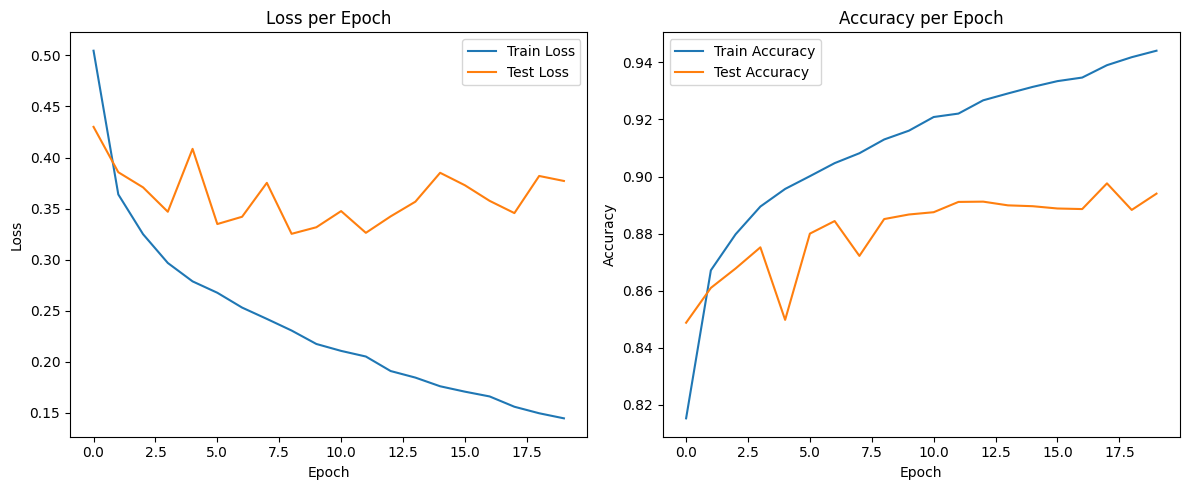

In [15]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to(device)
torchsummary.summary(model, (28*28,))

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(model, loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(out, dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_fn(out, y)
            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(out, dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    return running_loss/total, correct/total

epochs = 20
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    tr_loss, tr_acc = train(model, train_loader, opt, loss_func)
    te_loss, te_acc = evaluate(model, test_loader, loss_func)
    
    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    test_losses.append(te_loss)
    test_accuracies.append(te_acc)
    
    print(f"Epoch {epoch+1}/{epochs}:\n"
          f"Train Loss: {tr_loss:.4f}, Train Accuracy: {tr_acc:.4f}\n"
          f"Test Loss: {te_loss:.4f}, Test Accuracy: {te_acc:.4f}\n")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [16]:
# class FixedNeuralNetwork(nn.Module):
#     def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
#         super(self.__class__, self).__init__()
#         self.model = nn.Sequential(
#             nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
#             # Your network structure comes here
#             nn.Linear(input_shape, num_classes)
#         )
        
#     def forward(self, inp):       
#         out = self.model(inp)

# torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

# # model = FixedNeuralNetwork().to(device)
# # opt = # YOUR CODE HERE
# # loss_func = # YOUR CODE HERE

# # # Your experiments, come here

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                 [-1, 1024]       1,049,600
       BatchNorm1d-7                 [-1, 1024]           2,048
              ReLU-8                 [-1, 1024]               0
           Dropout-9                 [-1, 1024]               0
           Linear-10                  [-1, 512]         524,800
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

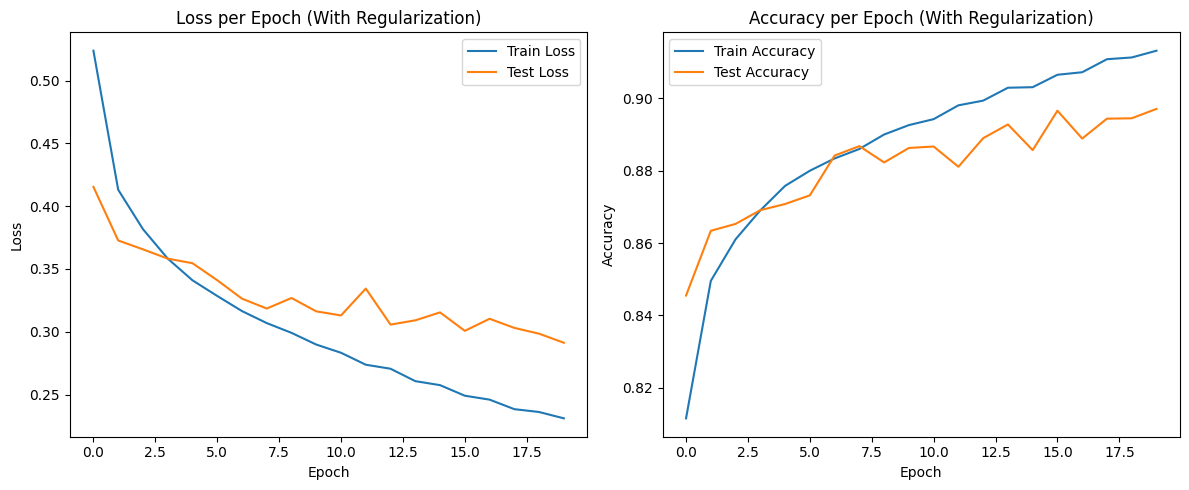

In [17]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

model = FixedNeuralNetwork().to(device)
torchsummary.summary(model, (28*28,))

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(model, loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(out, dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = loss_fn(out, y)
            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(out, dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    return running_loss/total, correct/total

epochs = 20
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    tr_loss, tr_acc = train(model, train_loader, opt, loss_func)
    te_loss, te_acc = evaluate(model, test_loader, loss_func)
    
    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    test_losses.append(te_loss)
    test_accuracies.append(te_acc)
    
    print(f"Epoch {epoch+1}/{epochs}:\n"
          f"Train Loss: {tr_loss:.4f}, Train Accuracy: {tr_acc:.4f}\n"
          f"Test Loss: {te_loss:.4f}, Test Accuracy: {te_acc:.4f}\n")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch (With Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch (With Regularization)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._



Переобучение:
Увеличение сложности модели (большее количество слоев и нейронов) при уменьшении обучающей выборки приводит к быстрому переобучению. Модель начинает идеально работать на обучающих данных, но плохо — на тестовых

Регуляризация:
Для борьбы с переобучением использовали Batch Normalization и Dropout. Это уменьшило точность на обучающих данных, но улучшило результаты на тестовых, сократив разрыв между кривыми обучения и валидации

Итог:
Избыточная сложность модели без регуляризации ведет к переобучению. Техники регуляризации, такие как BatchNorm и Dropout, повышают обобщающую способность модели